In [1]:
sc.addPyFile("../Pattern_extraction/Pattern_Extractor.py")
sc.addPyFile("../Pattern_extraction/Additional_tools.py")


import time
from Pattern_Extractor import Pattern_Extractor as Extractor
from Additional_tools import print_test_results
import os


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
#parameters
support = 0.001
intervals = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
maxDelta = 3 #how many spatial deltas
th = 0.5 #distance (seems in km)
window_size = 3 #how many time deltas
criticality_thresholds = [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]

support = 0.001

neighborhood_types = ['indegree', 'distance', 'indegree', 'distance', 'indegree', 'indegree', 'distance', 'indegree', 'distance', 'indegree', 'distance', 'indegree', 'indegree', 'distance']
n_neighborss = [10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 0, 10]
extraction_types = ['Empty-AlmostEmpty', 'Empty-AlmostEmpty', 'Empty-Increase', 'Empty-Increase', 'Empty-Decrease', 'Empty-Decrease', 'Empty-Decrease', 'Empty-AlmostEmpty', 'Empty-AlmostEmpty', 'Empty-Increase', 'Empty-Increase', 'Empty-Decrease', 'Empty-Decrease', 'Empty-Decrease']
incr_dec_threshold = 1 # 0 for threshold > 0
wrap_states = True
state_change = False
time_zone = None
target = 'AlmostEmpty'

status_path  = "datasets/SanFrancisco_status_train.csv"
#status_path = "datasets/small_status.csv"
stations_path = "bike_sharing/station.csv"
importance_path = "../../Datasets/edge_importance.csv"
status_path_test  = "datasets/SanFrancisco_status_test.csv"

for i in range(len(intervals)):
    interval = intervals[i]
    neighborhood_type = neighborhood_types[i]
    n_neighbors = n_neighborss[i]
    extraction_type = extraction_types[i]
    criticality_threshold = criticality_thresholds[i]
    
    ext = Extractor(interval, maxDelta, th, window_size, status_path, stations_path, spark, sc, criticality_threshold)
    df = ext.extract_items(extraction_type=extraction_type, neighborhood_type=neighborhood_type,
                       n_neighbors=n_neighbors, incr_dec_threshold=incr_dec_threshold, 
                       wrap_states=wrap_states, state_change=state_change, time_zone=time_zone,
                       importance_path=importance_path)
    prefix = ext.extract_frequent_items(df, support)
    
    zone_str = f"{time_zone}_" if time_zone != None else ''
    output_file = f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"
    #same directory, but written for bash
    output_file_b = f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}\({window_size}-{maxDelta}\).txt"

    if not os.path.exists(f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/"):
        os.makedirs(f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/")

    ext.save_classification_patterns(prefix, output_file)
    
    hdfs_dir = f"./Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/"
    
    !hdfs dfs -mkdir $hdfs_dir
    !hdfs dfs -put $output_file_b $hdfs_dir

    test_ext = Extractor(interval, maxDelta, th, window_size, status_path_test, stations_path, spark, sc, criticality_threshold)
    df_t = test_ext.extract_items(extraction_type=extraction_type, neighborhood_type=neighborhood_type,
                           n_neighbors=n_neighbors, incr_dec_threshold=incr_dec_threshold, 
                           wrap_states=wrap_states, state_change=state_change, for_test=True,
                           time_zone=time_zone, importance_path=importance_path, drop_nulls=True)

    conf_thresholds = [0.5, 0.7, 0.8, 0.9]
    sup_threshold = 0

    zone_str = f"{time_zone}_" if time_zone != None else ''
    patterns_file = f"./Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"
    print("File: ", patterns_file)

    for conf_threshold in conf_thresholds:
        filtered_patterns = ext.filter_patterns_conf_sup(patterns_file, conf_threshold, sup_threshold, target=target)
        rules = filtered_patterns.collect()

        extraction = f"{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}"
        neighborhood = f"{str(n_neighbors) if neighborhood_type=='indegree' else 'Dist'}"

        if len(rules)==0:
            break

        for match_threshold in [1, 5]:
            if len(rules) < match_threshold:
                break
        
            results = test_ext.test_rules(df_t, rules, match_threshold, target)
            for k in ['TP', 'FP', 'TN', 'FN']:      
                try:
                    tmp = results[k]
                except KeyError:# in case no predictions are done
                    results[k] = 0
            f = open(f"../../Results/Classification_patterns/Results_{target}/Classifier_results{zone_str}{criticality_threshold if criticality_threshold != 3 else ''}_{interval}_with_filtering.csv", "a")
            f.write(f"{test_ext.get_test_results(results, extraction, neighborhood, conf_threshold, match_threshold)}")
            f.close()

../../Results/Classification_patterns/Empty-AlmostEmpty_wrapped1/10_1_30_500_0.001(3-3).txt  saved successfully.
File:  ./Classification_patterns/Empty-AlmostEmpty_wrapped1/10_1_30_500_0.001(3-3).txt
All patterns were filtered.
Please choose looser rules.
../../Results/Classification_patterns/Empty-AlmostEmpty_wrapped1/Dist_1_30_500_0.001(3-3).txt  saved successfully.
mkdir: `Classification_patterns/Empty-AlmostEmpty_wrapped1': File exists
File:  ./Classification_patterns/Empty-AlmostEmpty_wrapped1/Dist_1_30_500_0.001(3-3).txt
All patterns were filtered.
Please choose looser rules.
../../Results/Classification_patterns/Empty-Increase_wrapped1/10_1_30_500_0.001(3-3).txt  saved successfully.
File:  ./Classification_patterns/Empty-Increase_wrapped1/10_1_30_500_0.001(3-3).txt
All patterns were filtered.
Please choose looser rules.
../../Results/Classification_patterns/Empty-Increase_wrapped1/Dist_1_30_500_0.001(3-3).txt  saved successfully.
mkdir: `Classification_patterns/Empty-Increase_wr

In [3]:
#parameters
support = 0.001
interval = 30 #time window
maxDelta = 3 #how many spatial deltas
th = 0.5 #distance (seems in km)
window_size = 3 #how many time deltas
criticality_threshold = 3 #threshold for AlmostFull
target = 'AlmostFull'

neighborhood_type = 'indegree'
n_neighbors = 10
extraction_type = 'Full-Decrease' # Full-AlmostFull or Empty-AlmostEmpty or 'Full-Decrease' or 'Empty-Increase' or 'Full-Increase'
incr_dec_threshold = 1 # 0 for threshold > 0
wrap_states = True
state_change = False
time_zone = None
extract_normal = True

In [4]:
status_path  = "datasets/SanFrancisco_status_train.csv"
#status_path = "datasets/small_status.csv"
stations_path = "bike_sharing/station.csv"
importance_path = "../../Datasets/edge_importance.csv"

ext = Extractor(interval, maxDelta, th, window_size, status_path, stations_path, spark, sc, criticality_threshold)

In [4]:
df = ext.extract_items(extraction_type=extraction_type, neighborhood_type=neighborhood_type,
                       n_neighbors=n_neighbors, incr_dec_threshold=incr_dec_threshold, 
                       wrap_states=wrap_states, state_change=state_change, 
                       for_test=extract_normal, time_zone=time_zone,
                       importance_path=importance_path)

In [5]:
support = 0.001
prefix = ext.extract_frequent_items(df, support)

In [9]:
zone_str = f"{time_zone}_" if time_zone != None else ''
output_file = f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"

if not os.path.exists(f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/"):
    os.makedirs(f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/")

ext.save_classification_patterns(prefix, output_file)

../../Results/Classification_patterns/Full-Decrease_wrapped_WN/10_1_30_500_0.001(3-3).txt  saved successfully.


In [10]:
hdfs_dir = f"./Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/"
output_file_b = f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}\({window_size}-{maxDelta}\).txt"

!hdfs dfs -mkdir $hdfs_dir
!hdfs dfs -put $output_file_b $hdfs_dir

mkdir: `Classification_patterns/Full-Decrease_wrapped_WN': File exists


In [11]:
!hdfs dfs -ls $hdfs_dir

Found 1 items
-rw-r-----   3 s287791 students    2812043 2022-05-16 10:52 Classification_patterns/Full-Decrease_wrapped_WN/10_1_30_500_0.001(3-3).txt


In [9]:
status_path_test  = "datasets/SanFrancisco_status_test.csv"

test_ext = Extractor(interval, maxDelta, th, window_size, status_path_test, stations_path, spark, sc, criticality_threshold)
df_t = test_ext.extract_items(extraction_type=extraction_type, neighborhood_type=neighborhood_type,
                       n_neighbors=n_neighbors, incr_dec_threshold=incr_dec_threshold, 
                       wrap_states=wrap_states, state_change=state_change, for_test=True,
                       time_zone=time_zone, importance_path=importance_path, drop_nulls=True)

In [28]:
df_t.show(20, False)

+---------------------------------------------------------------------------+
|sequence                                                                   |
+---------------------------------------------------------------------------+
|[[Increase_T0_0, Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]               |
|[[Increase_T0_0, Normal_T0_0], [Normal_T1_0], [Increase_T2_0, Normal_T2_0]]|
|[[Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]                              |
|[[Increase_T0_0, Normal_T0_0], [Normal_T1_0], [Increase_T2_0, Normal_T2_0]]|
|[[Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]                              |
|[[Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]                              |
|[[Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]                              |
|[[Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]                              |
|[[Normal_T0_0], [Normal_T1_0], [Normal_T2_0]]                              |
|[[Increase_T0_0, Normal_T0_0], [Increase_T1_0, Normal_T1_0], [N

In [14]:
conf_thresholds = [0.5, 0.7, 0.8]
sup_threshold = 0

zone_str = f"{time_zone}_" if time_zone != None else ''
patterns_file = f"./Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"
print("File: ", patterns_file)

for conf_threshold in conf_thresholds:
    filtered_patterns = ext.filter_patterns_conf_sup(patterns_file, conf_threshold, sup_threshold, target=target)
    rules = filtered_patterns.collect()
    
    extraction = f"{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}"
    neighborhood = f"{str(n_neighbors) if neighborhood_type=='indegree' else 'Dist'}"
    
    if len(rules)==0:
        break

    for match_threshold in [1, 5]:
        if len(rules) < match_threshold:
            break
        f = open(f"../../Results/Classification_patterns/Results_{target}/Classifier_results{zone_str}{criticality_threshold if criticality_threshold != 3 else ''}_{interval}_with_filtering.csv", "a")
        results = test_ext.test_rules(df_t, rules, match_threshold)
        f.write(f"{test_ext.get_test_results(results, extraction, neighborhood, conf_threshold, match_threshold)}")
        f.close()

File:  ./Classification_patterns/Full-Decrease_wrapped_WN/10_1_30_500_0.001(3-3).txt


File:  ./Classification_patterns/Full-Decrease_wrapped_WN/10_1_30_500_0.001(3-3).txt


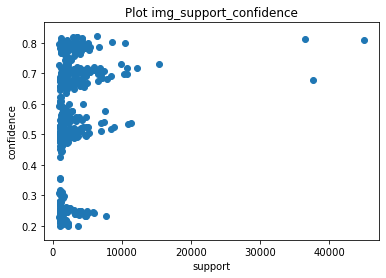

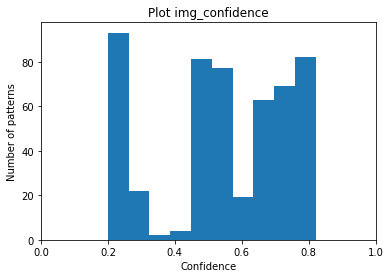

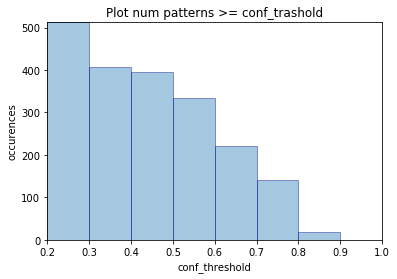

In [7]:
conf_threshold = 0.2
sup_threshold = 0
zone_str = f"{time_zone}_" if time_zone != None else ''
patterns_file = f"./Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}{criticality_threshold if criticality_threshold != 3 else ''}/{zone_str if time_zone != None else ''}{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"

print("File: ", patterns_file)

filtered_patterns = ext.filter_patterns_conf_sup(patterns_file, conf_threshold, sup_threshold, target=target)
ext.print_patterns_stats(filtered_patterns, conf_threshold)
rules = filtered_patterns.collect()

In [70]:
rules = [f"[[[['{target}_T0_0'], ['{target}_T1_0']]], ['0 - 0']]"]

In [ ]:
rules

In [ ]:
#extraction_type,neighborhood,confidence_threshold,match_threshold,accuracy,precision,recall,f1,TP,TN,FP,FN
extraction = f"{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}{'_WN' if extract_normal else ''}"
neighborhood = f"{str(n_neighbors) if neighborhood_type=='indegree' else 'Dist'}"

for match_threshold in [1]:
    f = open(f"../../Results/Classification_patterns/Results_{target}/Classifier_results{zone_str}{criticality_threshold if criticality_threshold != 3 else ''}_{interval}_with_filtering.csv", "a")
    results = test_ext.test_rules(df_t, rules, match_threshold, target)
    f.write(test_ext.get_test_results(results, "Dummy", neighborhood, conf_threshold, match_threshold))
    f.close()

In [ ]:
print_test_results(results)

In [ ]:
#test_ext.logga(df_t, rules).filter(lambda x:x!=None).saveAsTextFile('logs')